# Neural network classifier with one hidden layer

We will build a neural network with a single hidden layer for classification.
We use weight matrices $W_1 \in \mathbb R^{\ell \times n}, W_2 \in \mathbb R^{K \times \ell}$ and offsets $b_1 \in \mathbb R^\ell, b_2 \in \mathbb R^K$.
We use an activation function $f_1 \colon \mathbb R \to \mathbb R$ that we apply element-wise to the results of the first affine transformation $W_1 x + b_1$.
We merely use the identity function as activation function for the output layer. Overall, our classifier is thus
$$
    h_{(W_1, b_1, W_2, b_2)}(x) = W_2 f_1(W_1 x + b_1) + b_2.
$$
For the hidden layer, we use the activation function
$$
f_1(x) = \mathrm{ReLU}(x) = \max\{0, x\} .
$$
To keep our notation concise, we write $\theta = (W_1, b_1, W_2, b_2)$ to specify all learnable parameters used in our classifier.
We want to use the softmax
$$
    \mathrm{softmax}(s)_y = \frac{e^{s_y}}{\sum_{c=1}^K e^{s_c}}
$$
to map the class scores $s \in \mathbb R^K$ from the output layer to probabilities.
We use the cross-entropy loss with a regularizer. Our complete loss is therefore
$$
f_{\log}(\theta) = \frac 1 m \sum_{i=1}^m \underbrace{- \log (\mathrm{softmax}(h_\theta(x^{(i)})_{y^{(i)}}))}_{\textrm{Cross-entropy loss}} + \gamma \underbrace{(\|W_1\|_F^2 + \|W_2\|_F^2)}_{\textrm{Regularizer}}
$$
where $h_\theta(x^{(i)})_{y^{(i)}}$ refers to the $y^{(i)}$-th entry of the vector $h_\theta(x^{(i)})$, i.e. how much probability mass our classifier puts on the true label for example $(x^{(i)}, y^{(i)})$.

In [1]:
# Imports and setup
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_classification, make_moons
import numpy as np
import random

# Fix the random seed (for reproducibility)
random.seed(123)
np.random.seed(123)

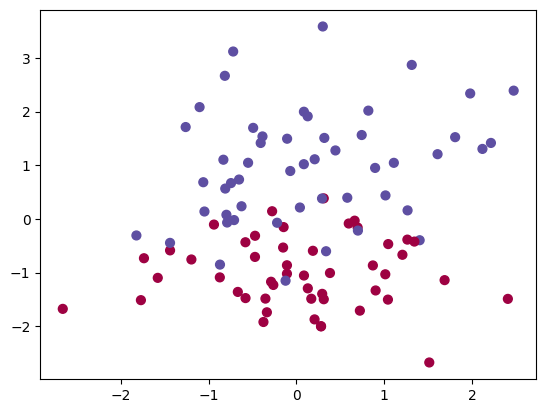

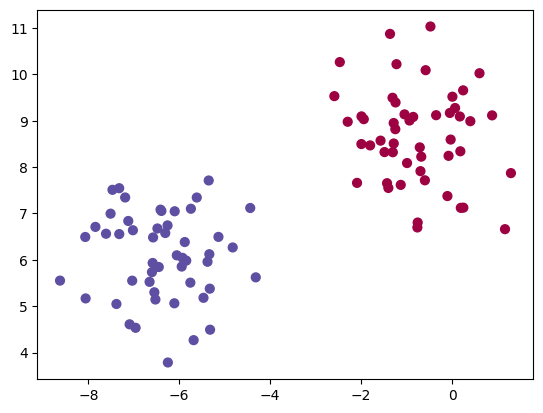

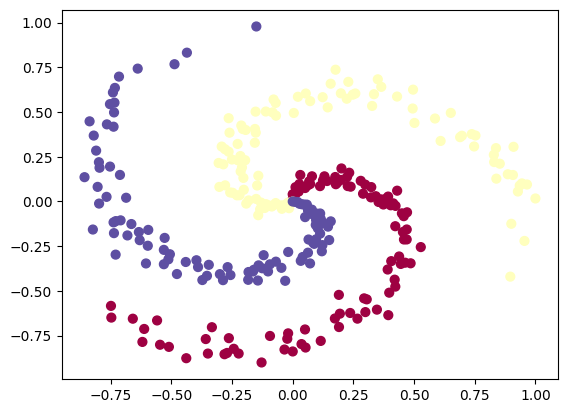

In [5]:
# Setting up the 2D datasets

# plot the feature vectors as points in the plane, colored according to the class
def plot_dataset(X, y):
    plt.figure()
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    plt.show()

# random binary classification  (almost linearly separable)
def dataset_binary(num_examples = 100):
    X, y = make_classification(n_samples = num_examples, n_features=2, n_redundant=0,
                               n_informative=1, n_clusters_per_class=1)
    return X, y

# blobs
def dataset_blobs(num_examples = 100, num_classes = 2, num_centers = 2):
    X, y = make_blobs(n_samples = num_examples, n_features=num_classes, centers=num_centers)
    return X,y

# moons
def dataset_moons(num_examples = 100):
    X, y = make_moons(n_samples = num_examples)
    return X, y

# spirals
def dataset_spirals(num_classes = 3, num_examples_per_class = 100):
    N = num_examples_per_class # number of points per class
    D = 2 # dimensionality
    K = num_classes # number of classes
    X = np.zeros((N*K,D)) # data matrix (each row = single example)
    y = np.zeros(N*K, dtype='uint8') # class labels

    for j in range(K):
        ix = range(N*j,N*(j+1))
        r = np.linspace(0.0,1,N) # radius
        t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = j
        
    return X, y

# example datasets
X, y = dataset_binary()
plot_dataset(X, y)

X, y = dataset_blobs()
plot_dataset(X, y)

X, y = dataset_spirals()
plot_dataset(X, y)

In [3]:
def nn_predict(X, W1, b1, W2, b2):
    hidden_layer = np.maximum(0, np.dot(X, W1.T) + b1) # ReLU activation
    scores = np.dot(hidden_layer, W2.T) + b2
    y_pred = np.argmax(scores, axis=1)
    return y_pred

def evaluate_accuracy(X, y, W1, b1, W2, b2):
    y_pred = nn_predict(X, W1, b1, W2, b2)
    accuracy = np.mean(y_pred == y)
    return accuracy

# plot the classifier
def vizualize_classifier(X, W1, b1, W2, b2):
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
    Z = np.dot(np.maximum(0, np.dot(np.c_[xx.ravel(), yy.ravel()], W1.T) + b1), W2.T) + b2
    Z = np.argmax(Z, axis=1)
    Z = Z.reshape(xx.shape)
    fig = plt.figure()
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

In [64]:
def nn_loss_grad(X, y, W1, b1, W2, b2, reg):
    """
    Compute the loss and gradients of the neural network.
    Feature vectors have dimension n, there are K classes, and m training examples.

    Inputs:
    - W: A numpy array of shape (K, n) containing weights.
    - X: A numpy array of shape (m, n) containing the training feature vectors 
        (row i of X is the feature vector of the i-th training example).
    - y: A numpy array of shape (m,) containing the training labels; y[i] = c means
      that X[i] has label c, where 0 <= c < K.
    - reg: (float) regularization strength (the gamma value from lecture)

    Returns a tuple of:
    - loss as single float
    - gradient with respect to weights W1; an array of same shape as W1
    - gradient with respect to the offsets b1; an array of the same shape as b1
    - gradient with respect to weights W2; an array of same shape as W2
    - gradient with respect to the offsets b2; an array of the same shape as b2
    """
    num_examples = X.shape[0]
    
    #Forward pass
    hidden_layer = np.maximum(0, X @ W1.T + b1) 
    scores = hidden_layer@W2.T + b2
    exp_scores = np.exp(scores - np.max(scores, axis=1, keepdims=True)) 
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    #loss calculation
    correct_class_probs = probs[range(num_examples), y]
    data_loss = -np.sum(np.log(correct_class_probs)) / num_examples
    reg_loss = reg * (np.sum(W1 * W1) + np.sum(W2 * W2))
    loss = data_loss + reg_loss
    
    #backpropagation
    dscores = probs
    dscores[range(num_examples), y] -= 1
    dscores /= num_examples
    
    dW2 = hidden_layer.T @ dscores
    db2 = np.sum(dscores, axis=0)
    
    dhidden = dscores @ W2
    dhidden[hidden_layer <= 0] = 0
    
    dW1 = X.T @ dhidden
    db1 = np.sum(dhidden, axis=0)
    
    #regularization
    dW1 = dW1.T + 2 * reg * W1
    dW2 = dW2.T + 2 * reg * W2

    return loss, dW1, db1, dW2, db2


def nn_train(X, y, step_size=1e-0, hidden_layer_size=100, reg=1e-3, num_iter=10000, verbose=True):
    """
    Train an neural network with a single hidden layer using  gradient descent.

    Inputs:
    - X: A numpy array of shape (m, n) containing the training feature vectors 
         (row i of X is the feature vector of the i-th training example).
    - y: A numpy array of shape (m,) containing the training labels; y[i] = c means
         that X[i] has label c, where 0 <= c < K.
    - step_size: (float) gradient descent step size.
    - hidden_layer_size: (int) size of the hidden layer.
    - gamma: (float) regularization strength.
    - num_iters: (integer) number of gradient descent iterations.
    - verbose: (boolean) If true, print progress during optimization.

    Outputs:
     - W1 : matrix of weights of the first layer
     - b1 : vector of offsets of the first layer
     - W1 : matrix of weights of the output layer
     - b1 : vector of offsets of the output layer
     """

    num_examples, num_features = X.shape
    num_classes = np.max(y) + 1 # assume y takes values 0...K-1 where K is number of classes

    # initialize parameters randomly
    W1 = 0.01 * np.random.randn(hidden_layer_size, num_features)
    b1 = np.zeros(hidden_layer_size)
    W2 = 0.01 * np.random.randn(num_classes, hidden_layer_size)
    b2 = np.zeros(num_classes)

    for i in range(num_iter):
        loss, dW1, db1, dW2, db2 = nn_loss_grad(X, y, W1, b1, W2, b2, reg)
        W1 -= step_size * dW1
        b1 -= step_size * db1.reshape(-1)
        W2 -= step_size * dW2
        b2 -= step_size * db2.reshape(-1)
        if verbose and i % 1000 == 0:
            print("iteration %d: loss %f" % (i, loss))

    return W1, b1, W2, b2

iteration 0: loss 0.692918
iteration 1000: loss 0.034759
iteration 2000: loss 0.034744
iteration 3000: loss 0.034744
iteration 4000: loss 0.034743
iteration 5000: loss 0.034742
iteration 6000: loss 0.034741
iteration 7000: loss 0.034738
iteration 8000: loss 0.034735
iteration 9000: loss 0.034729
Accuracy: 1.0


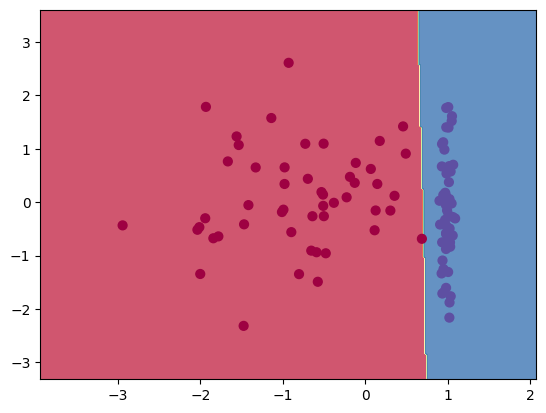

In [66]:
X, y = dataset_binary()
W1, b1, W2, b2 = nn_train(X, y, step_size=1e-0, hidden_layer_size=100, reg=1e-3, num_iter=10000, verbose=True)
print("Accuracy:", evaluate_accuracy(X, y, W1, b1, W2, b2))
vizualize_classifier(X, W1, b1, W2, b2)

iteration 0: loss 0.694108
iteration 1000: loss 0.004596
iteration 2000: loss 0.004269
iteration 3000: loss 0.004135
iteration 4000: loss 0.004032
iteration 5000: loss 0.003955
iteration 6000: loss 0.003898
iteration 7000: loss 0.003852
iteration 8000: loss 0.003815
iteration 9000: loss 0.003784
Accuracy: 1.0


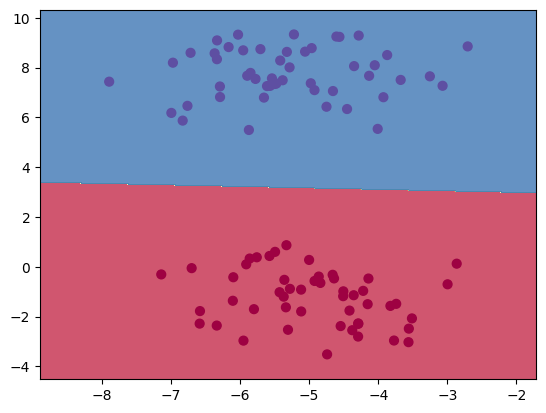

In [67]:
X, y = dataset_blobs()
W1, b1, W2, b2 = nn_train(X, y, step_size=1e-0, hidden_layer_size=100, reg=1e-3, num_iter=10000, verbose=True)
print("Accuracy:", evaluate_accuracy(X, y, W1, b1, W2, b2))
vizualize_classifier(X, W1, b1, W2, b2)

iteration 0: loss 0.693274
iteration 1000: loss 0.072394
iteration 2000: loss 0.072214
iteration 3000: loss 0.072180
iteration 4000: loss 0.072160
iteration 5000: loss 0.072114
iteration 6000: loss 0.072103
iteration 7000: loss 0.072093
iteration 8000: loss 0.072091
iteration 9000: loss 0.072085
Accuracy: 1.0


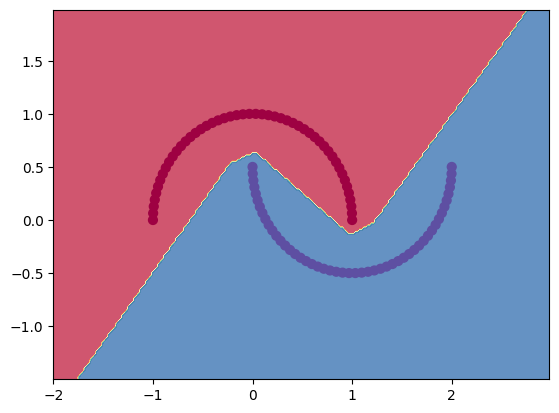

In [68]:
X, y = dataset_moons()
W1, b1, W2, b2 = nn_train(X, y, step_size=1e-0, hidden_layer_size=1000, reg=1e-3, num_iter=10000, verbose=True)
print("Accuracy:", evaluate_accuracy(X, y, W1, b1, W2, b2))
vizualize_classifier(X, W1, b1, W2, b2)

iteration 0: loss 1.099258
iteration 1000: loss 0.372594
iteration 2000: loss 0.354077
iteration 3000: loss 0.352223
iteration 4000: loss 0.351622
iteration 5000: loss 0.351372
iteration 6000: loss 0.351226
iteration 7000: loss 0.351146
iteration 8000: loss 0.351078
iteration 9000: loss 0.351025
Accuracy: 0.9733333333333334


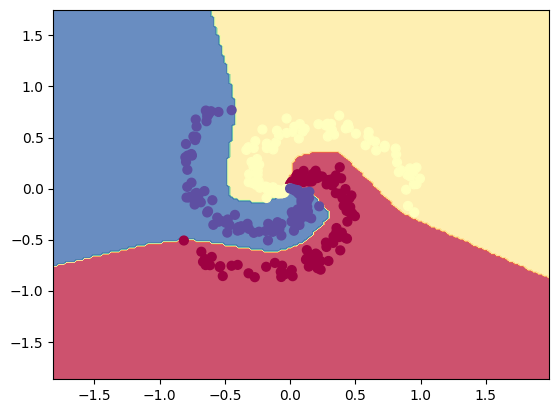

In [69]:
X, y = dataset_spirals()
W1, b1, W2, b2 = nn_train(X, y, step_size=1e-0, hidden_layer_size=1000, reg=1e-3, num_iter=10000, verbose=True)
print("Accuracy:", evaluate_accuracy(X, y, W1, b1, W2, b2))
vizualize_classifier(X, W1, b1, W2, b2)